<a href="https://colab.research.google.com/github/andresfelipecs/suena_application_test/blob/master/algotrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import tensorflow as tf
import time
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import TimeSeriesSplit
from itertools import product
import warnings


# Loading data

In [ ]:
# Loading the data into a Pandas DataFrame
df_auction = pd.read_csv("/content/sample_data/auction_data.csv", sep=';', header=0)

# Setting the first column as an index 
df_auction['Date (WET)'] = pd.to_datetime(df_auction['Date (WET)'], format='[%d/%m/%Y %H:%M]')
# df_auction['date'] = df_auction['Date (WET)']
df_auction.set_index('Date (WET)', inplace=True)


# Droping the first row
units_auction = df_auction.iloc[0]
print(units_auction)

df_auction = df_auction.drop(df_auction.index[0])


# Showing the data 
print(df_auction)
# print(f'INDEX:  {df_auction.index} \n')
# print(f'TYPE:  {df_auction.dtypes} \n')
# print(f'SHAPE:  {df_auction.shape} \n')
print(f"COLUMNS: {df_auction.columns} \n")

# print(f'ROW {df_auction.loc["2021-01-01 00:00:00" ]}')


# Converting all the elements in the df_auction dataframe to numerical values, so that the data can be used for numerical computations and visualizations.
df_auction = df_auction.apply(pd.to_numeric, errors='coerce')
# The errors='coerce' argument is used to handle any elements that can't be converted to numerical values. 
# When errors='coerce', any non-numerical values will be replaced with NaN (Not a Number) values.




In [ ]:
df_forecast_inputs = pd.read_csv(
            "/content/sample_data/forecast_inputs.csv"
        , sep=';', header=0)

# Setting the first column as an index 
df_forecast_inputs['Date (WET)'] = pd.to_datetime(df_forecast_inputs['Date (WET)'], format='[%d/%m/%Y %H:%M]')
df_forecast_inputs.set_index('Date (WET)', inplace=True)

# Dropping the first row
units_forecast_inputs = df_forecast_inputs.iloc[0]
print(units_forecast_inputs)

df_forecast_inputs = df_forecast_inputs.drop(df_forecast_inputs.index[0])

df_forecast_inputs = df_forecast_inputs.apply(pd.to_numeric, errors='coerce')


print(df_forecast_inputs)




In [ ]:
df_system_prices = pd.read_csv(
            "/content/sample_data/system_prices.csv"
        , sep=';', header=0)

# Setting the first column as an index 
df_system_prices['Date (WET)'] = pd.to_datetime(df_system_prices['Date (WET)'], format='[%d/%m/%Y %H:%M]')
df_system_prices.set_index('Date (WET)', inplace=True)

# Dropping the first row
units_system_prices = df_system_prices.iloc[0]
print(units_system_prices)

df_system_prices = df_system_prices.drop(df_system_prices.index[0])

df_system_prices = df_system_prices.apply(pd.to_numeric, errors='coerce')


print(df_system_prices)



# Cleaning and Splitting the data into training and testing sets

In [ ]:
from scipy.stats.distributions import norm

# Filling NaN with mode 
df_auction.fillna(df_auction.mode().iloc[0], inplace=True)
df_forecast_inputs.fillna(df_forecast_inputs.mode().iloc[0], inplace=True)
df_system_prices.fillna(df_system_prices.mode().iloc[0], inplace=True)

train_auction = df_auction[df_auction.index < '2022-03-01']
train_auction = train_auction.apply(pd.to_numeric, errors='coerce')

test_auction = df_auction[df_auction.index >= '2022-03-01']
test_auction = test_auction.apply(pd.to_numeric, errors='coerce')

train_forecast_inputs = df_forecast_inputs[df_forecast_inputs.index < '2022-03-01']
train_forecast_inputs = train_forecast_inputs.apply(pd.to_numeric, errors='coerce')

test_forecast_inputs = df_forecast_inputs[df_forecast_inputs.index >= '2022-03-01']
test_forecast_inputs = test_forecast_inputs.apply(pd.to_numeric, errors='coerce')

train_system_prices = df_system_prices[df_system_prices.index < '2022-03-01']
train_system_prices = train_system_prices.apply(pd.to_numeric, errors='coerce')

test_system_prices = df_system_prices[df_system_prices.index >= '2022-03-01']
test_system_prices = test_system_prices.apply(pd.to_numeric, errors='coerce')

# Using scaler to normalize ALL the data 
scaler = StandardScaler()

all_data = pd.concat([df_auction, df_forecast_inputs, df_system_prices], axis=1)
all_data = all_data.apply(pd.to_numeric, errors='coerce')
all_data = pd.DataFrame(scaler.fit_transform(all_data), columns=all_data.columns, index=all_data.index)


normalized_train_data = all_data[all_data.index < '2022-03-01']
normalized_test_data = all_data[all_data.index >= '2022-03-01']

normalized_train_auction = normalized_train_data[df_auction.columns]
normalized_test_auction = normalized_test_data[df_auction.columns]

normalized_train_forecast_inputs = normalized_train_data[df_forecast_inputs.columns]
normalized_test_forecast_inputs = normalized_test_data[df_forecast_inputs.columns]

normalized_train_system_prices = normalized_train_data[df_system_prices.columns]
normalized_test_system_prices = normalized_test_data[df_system_prices.columns]

print(normalized_train_auction)

# Making sure there are not NaN or inf values 
print(f"train auction null data {train_auction.isnull().sum().sum()}")
print(f"train auction inf data {np.isinf(train_auction).sum().sum()}")

print(f"train forecast input null data {train_forecast_inputs.isnull().sum().sum()}")
print(f"tran forecast input inf data {np.isinf(train_forecast_inputs).sum().sum()}")


print(f"train system price null data {train_system_prices.isnull().sum().sum()}")
print(f"traion system price inf data {np.isinf(train_system_prices).sum().sum()}")




# Checking the shapes of the resulting training and testing sets





In [ ]:

print("train_auction shape: ", train_auction.shape)
print("test_auction shape: ", test_auction.shape)

print("train_forecast_inputs shape: ", train_forecast_inputs.shape)
print("test_forecast_inputs shape: ", test_forecast_inputs.shape)

print("train_system_prices shape: ", train_system_prices.shape)
print("test_system_prices shape: ", test_system_prices.shape)

# Tensor flow & keras: **Neural network**, **model** and **forecast** (sequential neural network type DNN (Deep Neural Network) model )

In [ ]:

# Splitting the input data into features and target
train_features = normalized_train_auction.drop('price_second_auction', axis=1)
train_target = normalized_train_auction['price_second_auction']
# Concatenating the other datasets with the training features
train_features = np.concatenate((train_features, normalized_train_forecast_inputs, normalized_train_system_prices), axis=1)

# Building the neural network model using TensorFlow
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape=(train_features.shape[1],)))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.LeakyReLU(alpha=0.1))
model.add(tf.keras.layers.Dense(1))

# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Defining callbacks to monitor the training process
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
]

# Trainning the model on the training data
history = model.fit(train_features, train_target, epochs=100, batch_size=32, validation_split=0.2, callbacks=callbacks)


# With this approach we are only focusing on getting the train_forecast with the other variables without the system knowing train_forecast itself
# Same approach is done for the test_forecast, in this case using the test_feautures, normalized_test_forecast_inputs, normalized_test_system_prices variables.
# Later (ideally) would be trying to get the test_forecast with the train_features only, so it works as real life when we want to predict the future values
# That can be done with different approaches, nevertheless complex models need a lot of computation, in that case a paid GPU
# might be neccesary to achive better results, to improve model preformance and running time.

# Using the trained model to make predictions on the train data
train_forecast = model.predict(train_features)

# Using the trained model to make predictions on the test data
test_features = normalized_test_auction.drop('price_second_auction', axis=1)

# Concatenating the other datasets with the test features
test_features = np.concatenate((test_features, normalized_test_forecast_inputs, normalized_test_system_prices), axis=1)

test_forecast = model.predict(test_features)

print(f"train forecast {train_forecast.shape}")
print(f"test forecast {test_forecast.shape}")

# Summary: 
# The model built using TensorFlow is a sequential neural network type DNN (Deep Neural Network) model, as it consists of multiple densely connected layers of neuron. 
# The model has three dense layers with 64 neurons in each layer and uses the Rectified Linear Unit (ReLU) activation function
# for the first two layers and a linear activation function for the last layer. 
# The model is trained using the Adam optimizer with a learning rate of 0.001 and the mean squared error loss function. 
# The model is also monitored using several callbacks, including EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau. 
# The trained model is then used to make predictions on the train and test data.



## Performance scores

## Results plot:  **train second auction**, **test second auction**, **train forecast**, **test forecast**

In [ ]:
# print(train_forecast)
# print(test_forecast)
# Creating a dataframe for the train forecast
train_forecast_df = pd.DataFrame(train_forecast, index=normalized_train_auction.index, columns=['price_second_auction_forecast'])

# Creating a dataframe for the test forecast
test_forecast_df = pd.DataFrame(test_forecast, index=normalized_test_auction.index, columns=['price_second_auction_forecast'])

fig = make_subplots()

fig.add_trace(go.Scatter(x=normalized_train_auction.index, y=normalized_train_auction['price_second_auction'], name='Train Price Second Auction', line=dict(color='#80b1d3')))
fig.add_trace(go.Scatter(x=train_forecast_df.index, y=train_forecast_df['price_second_auction_forecast'], name='Train Price Second Auction Forecast', line=dict(color='#fdb462', width=0.8)))

fig.add_trace(go.Scatter(x=normalized_test_auction.index, y=normalized_test_auction['price_second_auction'], name='Test Price Second Auction', line=dict(color='#fb8072')))
fig.add_trace(go.Scatter(x=test_forecast_df.index, y=test_forecast_df['price_second_auction_forecast'], name='Test Price Second Auction Forecast', line=dict(color='#8dd3c7', width=0.8)))

fig.update_layout(title='Normalized Train and Test Forecasts Second Auction')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')

fig.show()

## Plotting train **prices** and **volume** 

In [ ]:


fig = make_subplots(
            rows=2,
            cols=2,
            shared_xaxes=True,
            vertical_spacing=0.08,
            subplot_titles=("1st Action Prices", "2nd Action Prices", "1st Action Volume", "2nd Action Volume"),
            row_width=[0.2, 0.7],
        )

fig.add_trace(
            go.Scatter(x=normalized_train_auction.index, y=normalized_train_auction["price_first_auction"], mode="lines", line_shape="spline", name="Train Price First Auction", line=dict(color='#80b1d3')),
            row=1,
            col=1,
        )
fig.add_trace(
            go.Scatter(x=normalized_train_auction.index, y=normalized_train_auction["price_second_auction"], mode="lines", line_shape="spline", name="Train Price Second Auction", line=dict(color='#fb8072')),
            row=1,
            col=2,
        )

fig.add_trace(
            go.Bar(
                x=normalized_train_auction.index,
                y=normalized_train_auction["traded_volume_first_auction"],
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=1,
        )

fig.add_trace(
            go.Bar(
                x=normalized_train_auction.index,
                y=normalized_train_auction["traded_volume_second_auction"],
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=2,
        )

fig.add_trace(
            go.Scatter(
                x=normalized_train_auction.index,
                y=normalized_train_auction["price_forecast_first_auction"],
                mode="lines",
                name="Price train forecast first auction",
                line=dict(color="#fdb462", width=0.5),
            ),
            row=1,
            col=1,
        )

fig.add_trace(
            go.Scatter(
                x=train_forecast_df.index,
                y=train_forecast_df['price_second_auction_forecast'],
                mode="lines",
                name="Price train forecast second auction",
                line=dict(color="#80b1d3", width=0.5),
            ),
            row=1,
            col=2,
        )
            
fig.update_layout(title='Normalized Training Actions Prices and Volumes')
fig.update_yaxes(title='Price', row=1)
fig.update_xaxes(title='Date', row=2)

fig.show()

## Plotting normalized test **prices** and **volume** 

In [ ]:

fig = make_subplots(
            rows=2,
            cols=2,
            shared_xaxes=True,
            vertical_spacing=0.08,
            subplot_titles=("1st Action Prices", "2nd Action Prices", "1st Action Volume", "2nd Action Volume"),
            row_width=[0.2, 0.7],
        )

fig.add_trace(
            go.Scatter(x=normalized_test_auction.index, y=normalized_test_auction["price_first_auction"], mode="lines", line_shape="spline",name="Test Price First Auction ", line=dict(color='#80b1d3')),
            row=1,
            col=1,
        )
fig.add_trace(
            go.Scatter(x=normalized_test_auction.index, y=normalized_test_auction["price_second_auction"], mode="lines", line_shape="spline",name="Test Price Second Auction", line=dict(color='#fb8072')),
            row=1,
            col=2,
        )

fig.add_trace(
            go.Bar(
                x=normalized_test_auction.index,
                y=normalized_test_auction["traded_volume_first_auction"],
                
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=1,
        )

fig.add_trace(
            go.Bar(
                x=normalized_test_auction.index,
                y=normalized_test_auction["traded_volume_second_auction"],
                
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=2,
        )

fig.add_trace(
            go.Scatter(
                x=normalized_test_auction.index,
                y=normalized_test_auction["price_forecast_first_auction"],
                mode="lines",
                name="Price train forecast first auction",
                line=dict(color="#fdb462", width=0.5),
            ),
            row=1,
            col=1,
        )

fig.add_trace(
            go.Scatter(
                x=test_forecast_df.index,
                y=test_forecast_df['price_second_auction_forecast'],
                mode="lines",
                name="Price train forecast second auction",
                line=dict(color="#80b1d3", width=0.5),
            ),
            row=1,
            col=2,
        )

fig.update_layout(title='Normalized Test Actions Prices and Volumes', showlegend=True)
fig.update_yaxes(title='Price', row=1)
fig.update_xaxes(title='Date', row=2)

fig.show()

In [ ]:

# Getting the mean and standard deviation used during normalization
mean = scaler.mean_[0]
std = scaler.scale_[0]

# Denormalizing the train forecast
train_forecast_df['price_second_auction_forecast'] = train_forecast_df['price_second_auction_forecast'] * std + mean
# Denormalizing the test forecast
test_forecast_df['price_second_auction_forecast'] = test_forecast_df['price_second_auction_forecast'] * std + mean

print(f"train forecast df : {train_forecast_df['price_second_auction_forecast']}")
print(f"test forecast df {test_forecast_df['price_second_auction_forecast']}")





##  Denormalized Plots: (Results) (train **prices** and **volume**) (test **prices** and **volume**)

In [ ]:
# print(train_auction)
# print(test_auction)

fig = make_subplots()

fig.add_trace(go.Scatter(x=train_auction.index, y=train_auction['price_second_auction'], name='Train Price Second Auction', line=dict(color='#80b1d3')))
fig.add_trace(go.Scatter(x=train_forecast_df.index, y=train_forecast_df['price_second_auction_forecast'], name='Train Price Second Auction Forecast', line=dict(color='#fdb462', width=0.5)))

fig.add_trace(go.Scatter(x=test_auction.index, y=test_auction['price_second_auction'], name='Test Price Second Auction', line=dict(color='#fb8072')))
fig.add_trace(go.Scatter(x=test_forecast_df.index, y=test_forecast_df['price_second_auction_forecast'], name='Test Price Second Auction Forecast', line=dict(color='#8dd3c7', width=0.5)))

fig.update_layout(title='Denormalized Train and Test Forecasts Second Auction ')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')

fig.show()



In [ ]:

fig = make_subplots(
            rows=2,
            cols=2,
            shared_xaxes=True,
            vertical_spacing=0.08,
            subplot_titles=("1st Action Prices", "2nd Action Prices", "1st Action Volume", "2nd Action Volume"),
            row_width=[0.2, 0.7],
        )

fig.add_trace(
            go.Scatter(x=train_auction.index, y=train_auction["price_first_auction"], mode="lines", line_shape="spline", name="Train Price First Auction", line=dict(color='#80b1d3')),
            row=1,
            col=1,
        )
fig.add_trace(
            go.Scatter(x=train_auction.index, y=train_auction["price_second_auction"], mode="lines", line_shape="spline", name="Train Price Second Auction", line=dict(color='#fb8072')),
            row=1,
            col=2,
        )

fig.add_trace(
            go.Bar(
                x=train_auction.index,
                y=train_auction["traded_volume_first_auction"],
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=1,
        )

fig.add_trace(
            go.Bar(
                x=train_auction.index,
                y=train_auction["traded_volume_second_auction"],
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=2,
        )

fig.add_trace(
            go.Scatter(
                x=train_auction.index,
                y=train_auction["price_forecast_first_auction"],
                mode="lines",
                name="Price train forecast first auction",
                line=dict(color="#fdb462", width=0.5),
            ),
            row=1,
            col=1,
        )

fig.add_trace(
            go.Scatter(
                x=train_forecast_df.index,
                y=train_forecast_df['price_second_auction_forecast'],
                mode="lines",
                name="Price train forecast second auction",
                line=dict(color="#80b1d3", width=0.5),
            ),
            row=1,
            col=2,
        )
            
fig.update_layout(title='Denormalized Training Actions Prices and Volumes')
fig.update_yaxes(title='Price', row=1)
fig.update_xaxes(title='Date', row=2)

fig.show()

In [ ]:

fig = make_subplots(
            rows=2,
            cols=2,
            shared_xaxes=True,
            vertical_spacing=0.08,
            subplot_titles=("1st Action Prices", "2nd Action Prices", "1st Action Volume", "2nd Action Volume"),
            row_width=[0.2, 0.7],
        )

fig.add_trace(
            go.Scatter(x=test_auction.index, y=test_auction["price_first_auction"], mode="lines", line_shape="spline",name="Test Price First Auction ", line=dict(color='#80b1d3')),
            row=1,
            col=1,
        )
fig.add_trace(
            go.Scatter(x=test_auction.index, y=test_auction["price_second_auction"], mode="lines", line_shape="spline",name="Test Price Second Auction", line=dict(color='#fb8072')),
            row=1,
            col=2,
        )

fig.add_trace(
            go.Bar(
                x=test_auction.index,
                y=test_auction["traded_volume_first_auction"],
                
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=1,
        )

fig.add_trace(
            go.Bar(
                x=test_auction.index,
                y=test_auction["traded_volume_second_auction"],
                
                showlegend=False,
                marker=dict(
                    opacity=1,
                    line=dict(width=2, color="#ffffb3"),
                ),
            ),
            row=2,
            col=2,
        )

fig.add_trace(
            go.Scatter(
                x=test_auction.index,
                y=test_auction["price_forecast_first_auction"],
                mode="lines",
                name="Price train forecast first auction",
                line=dict(color="#fdb462", width=0.5),
            ),
            row=1,
            col=1,
        )

fig.add_trace(
            go.Scatter(
                x=test_forecast_df.index,
                y=test_forecast_df['price_second_auction_forecast'],
                mode="lines",
                name="Price train forecast second auction",
                line=dict(color="#80b1d3", width=0.5),
            ),
            row=1,
            col=2,
        )

fig.update_layout(title='Denormalized Test Actions Prices and Volumes', showlegend=True)
fig.update_yaxes(title='Price', row=1)
fig.update_xaxes(title='Date', row=2)

fig.show()

# Tensor flow & keras: predictions with Kfold validations (1D Convolutional Neural Network (CNN))

In [ ]:

# Splitting the input data into features and target
train_features = normalized_train_auction.drop('price_second_auction', axis=1)
train_target = normalized_train_auction['price_second_auction']
# Concatenating the other datasets with the training features
train_features = np.concatenate((train_features, normalized_train_forecast_inputs, normalized_train_system_prices), axis=1)

# Defining the number of folds for the K-fold cross-validation
n_folds = 5

# Initializing a KFold object with the number of folds
kfold = KFold(n_splits=n_folds, shuffle=True)

# Initializing arrays to store the results of the cross-validation
cv_scores = []
cv_histories = []

# Looping over the folds
for train_idx, val_idx in kfold.split(train_features):
    # Splitting the data into training and validation sets for each fold
    x_train, x_val = train_features[train_idx], train_features[val_idx]
    y_train, y_val = train_target[train_idx], train_target[val_idx]
    
    # Building the neural network model using TensorFlow
    model = tf.keras.models.Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_absolute_error'])

    # Defining callbacks to monitor the training process
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10),
        ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
    ]

    # Reshaping the data to include a channel dimension
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)

    # Training the model on the training data for each fold
    history = model.fit(x_train, y_train, epochs=100, batch_size=32, validation_data=(x_val, y_val), callbacks=callbacks)

    # Evaluating the model on the validation data for each fold
    score = model.evaluate(x_val, y_val, verbose=0)

    # Appending the results of the fold to the arrays
    cv_scores.append(score)
    cv_histories.append(history)

# Calculating the average performance of the model across all folds
mean_score = np.mean(cv_scores, axis=0)

# Printing the average performance of the model
print("Average performance on validation data:")
print("Loss: ", mean_score[0])
print("Mean Absolute Error: ", mean_score[1])


# Using the trained model to make predictions on the train data
validated_train_forecast = model.predict(train_features)

print(validated_train_forecast)
print(validated_train_forecast.shape)

# Use the trained model to make predictions on the test data
test_features = normalized_test_auction.drop('price_second_auction', axis=1)

# Concatenate the other datasets with the test features
test_features = np.concatenate((test_features, normalized_test_forecast_inputs, normalized_test_system_prices), axis=1)

validated_test_forecast = model.predict(test_features)


# Summary: 
# The model being used is a 1D Convolutional Neural Network (CNN) built using TensorFlow. 
# It has multiple layers, including two 1D convolutional layers, two max pooling layers, a flatten layer, two dense layers, and a dropout layer. 
# It's trained using the Adam optimizer with a learning rate of 0.001 and the mean squared error (MSE) loss function. 
# It's also monitored using several callbacks, including EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau. 
# Performming K-fold cross-validation, where the data is split into training and validation sets for each fold, and the model is trained and evaluated on each fold. 
# Finally, the trained model is used to make predictions on the train and test data.

# Decided to change the model to CNN, one most commonly used for time series forecasting to validate and compare results with the previous model.
# It is also recommended to do K-fold cross-validation in order to have a better performace estimation, reduce overfitting and helps us identifying 
# the model stability. If the performance scores low variability across different folds, it suggests that the model may perform well on unseen data.

# This model approach, as the previous one, is using the train_features wihtout the second_price_auction to find the train_forecast
#  and the test_features wihtout the second_price_auction to find the test_forecast


## Performance scores

In [ ]:

# Calculate the mean and standard deviation of the target variable
target_mean = np.mean(normalized_train_auction['price_second_auction'])
target_std = np.std(normalized_train_auction['price_second_auction'])

# Print the results
print("Target Mean: ", target_mean)
print("Target Standard Deviation: ", target_std)

# Print the average performance of the model
print("Average performance on validation data:")
print("Loss: ", mean_score[0])
print("Mean Absolute Error: ", mean_score[1])

# Based on the performance metrics, the model is performing relatively well. 
# The average loss value of 0.064 and mean absolute error value of 0.107 
# It indicates that the model is making predictions that are relatively close to the true values, 
# with an average absolute difference of approximately 0.11 between the predicted and true values.


## Results plot: Plotting validated normalized values 

In [ ]:
print(validated_train_forecast)
print(validated_test_forecast)

# Creating a dataframe for the train forecast
validated_train_forecast_df = pd.DataFrame(validated_train_forecast, index=normalized_train_auction.index, columns=['price_second_auction_forecast'])

# Creating a dataframe for the test forecast
validated_test_forecast_df = pd.DataFrame(validated_test_forecast, index=normalized_test_auction.index, columns=['price_second_auction_forecast'])

fig = make_subplots()

fig.add_trace(go.Scatter(x=normalized_train_auction.index, y=normalized_train_auction['price_second_auction'], name='Train Price Second Auction', line=dict(color='#80b1d3')))
fig.add_trace(go.Scatter(x=validated_train_forecast_df.index, y=validated_train_forecast_df['price_second_auction_forecast'], name='Train Price Second Auction Forecast', line=dict(color='#fdb462', width=0.8)))

fig.add_trace(go.Scatter(x=normalized_test_auction.index, y=normalized_test_auction['price_second_auction'], name='Test Price Second Auction', line=dict(color='#fb8072')))
fig.add_trace(go.Scatter(x=validated_test_forecast_df.index, y=validated_test_forecast_df['price_second_auction_forecast'], name='Test Price Second Auction Forecast', line=dict(color='#8dd3c7', width=0.8)))

fig.update_layout(title='Normalized Train and Test Forecasts Second Auction')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')

fig.show()

In [ ]:
start_date = pd.Timestamp('2022-02-28 23:00:00')
end_date = pd.Timestamp('2022-09-12 23:00:00')

# Calculate the number of hours between start_date and end_date
n_hours = (end_date - start_date).total_seconds() / 3600

print("Number of hours between start and end dates:", n_hours)



The appropriate time horizon for an accurate forecasts depends on the specific domain and the quality of the data we are working with. In the context of electricity price forecasting, short-term forecasts (e.g., a few hours to a few days ahead) are generally more accurate than long-term forecasts (e.g., weeks or months ahead) because there are fewer uncertainties involved in the short term. We could proove it when trying to make a forecast with unseen data for the test the results for long-term (10 months) forecast were not matching the test data. Different in the first models that we had becasue we were using other variables in the same datetime index in roder to find the forecast so the model was able to learn from current data and find really close predictions for the variable we are looking for. 

For the given data, it seems reasonable to focus on a short-term forecast, perhaps up to 24-48 hours ahead. This time horizon would allow us to capture daily patterns and fluctuations in the data, while still maintaining a reasonable level of accuracy. Keeping in mind that forecast accuracy will generally decrease as the forecasting horizon increases, so it's essential to evaluate the performance of our forecasting model and understand its limitations for longer time horizons.

In the next models we are going to focus on getting short-time accurate forecast with unseen data as would be for real life trading. And then compare which model give us better predictions in order to use the data for our strategies in a double auction. 

# XGBoost mode: Predictions with Kfold validations 

In [ ]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

def extract_features_from_past_data(normalized_train_auction, normalized_train_forecast_inputs, normalized_train_system_prices):
    train_features = pd.concat([normalized_train_auction,
                                  normalized_train_forecast_inputs,
                                  normalized_train_system_prices], axis=1)
    return train_features

train_features = extract_features_from_past_data(normalized_train_auction, normalized_train_forecast_inputs, normalized_train_system_prices)

# print(train_features)

# Prepare the train data and target variable
train_data = train_features['price_second_auction']

# Number of hours we want to predict into the future
n_hours_for_prediction = 2 * 24

train_features = train_features[:-n_hours_for_prediction]
test_features = train_features[-n_hours_for_prediction:]

train_target = train_data[:-n_hours_for_prediction]
test_target = train_data[-n_hours_for_prediction:]

# Set up the K-Fold cross-validation
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Define the XGBoost model
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=3, random_state=42)

mse_scores = []

# Perform cross-validation
for train_index, test_index in kf.split(train_features):
    X_train, X_test = train_features.iloc[train_index], train_features.iloc[test_index]
    y_train, y_test = train_target.iloc[train_index], train_target.iloc[test_index]
    
    # Train the model
    xgbr.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = xgbr.predict(X_test)
    
    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

# Calculate the mean and standard deviation of the MSE scores from cross-validation
mean_mse = np.mean(mse_scores)
std_mse = np.std(mse_scores)

print("Mean MSE from Cross-Validation:", mean_mse)
print("Standard Deviation of MSE from Cross-Validation:", std_mse)

# Train the model on the entire dataset
xgbr.fit(train_features, train_target)

# Predict the next 2 * 24 hours
prediction = xgbr.predict(test_features)

# Assuming train_features has a DateTimeIndex
predict_period_dates = pd.date_range('2022-03-01', periods=n_hours_for_prediction, freq="H").tolist()

# Create a DataFrame with the forecast dates and predictions
forecast_df = pd.DataFrame({'DateTime': predict_period_dates, 'Prediction': prediction})

# print(forecast_df)

# Plot the predictions using Plotly
fig = go.Figure()

# Add a trace for the predictions
fig.add_trace(go.Scatter(x=forecast_df['DateTime'], y=forecast_df['Prediction'], mode='lines', name='Predictions'))

fig.update_layout(title='Future Price Predictions',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.show()



## Results plot: Normalized trin and comparison between forecast df made by XGBoost model with unseen data and the given test data 

In [ ]:
# print(forecast_df.index)

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Select data within the desired time range
train_start_date = '2022-02-26'
train_end_date = normalized_train_auction.index.max()
train_mask = (normalized_train_auction.index >= train_start_date) & (normalized_train_auction.index <= train_end_date)
train_df = normalized_train_auction.loc[train_mask]

validated_start_date = '2022-02-26'
validated_end_date = validated_train_forecast_df.index.max()
validated_mask = (validated_train_forecast_df.index >= validated_start_date) & (validated_train_forecast_df.index <= validated_end_date)
validated_df = validated_train_forecast_df.loc[validated_mask]

test_start_date = '2022-03-01'
test_end_date = '2022-03-04'
test_mask = (normalized_test_auction.index >= test_start_date) & (normalized_test_auction.index <= test_end_date)
test_df = normalized_test_auction.loc[test_mask]

forecast_mask = (forecast_df['DateTime'] >= test_start_date) & (forecast_df['DateTime'] <= test_end_date)
forecast_df = forecast_df.loc[forecast_mask]

# Create the subplots and add the traces
fig = make_subplots()

fig.add_trace(go.Scatter(x=train_df.index, y=train_df['price_second_auction'], name='Train Price Second Auction', line=dict(color='#80b1d3')))
fig.add_trace(go.Scatter(x=validated_df.index, y=validated_df['price_second_auction_forecast'], name='Train Price Second Auction Forecast', line=dict(color='#fdb462', width=0.8)))

fig.add_trace(go.Scatter(x=test_df.index, y=test_df['price_second_auction'], name='Test Price Second Auction', line=dict(color='#fb8072')))
fig.add_trace(go.Scatter(x=forecast_df['DateTime'], y=forecast_df['Prediction'], name='Test Price Second Auction Forecast', line=dict(color='#8dd3c7')))

# Update the layout
fig.update_layout(title='Normalized Train and Test Forecasts Second Auction')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')

# Show the plot
fig.show()


# SARIMAX
Unfortunately this approach takes a lot of system RAM and also time to run and the predictions are not better as the ones we got from the previous model.Nevertheless with a GPU with more memory perhaps in the cloud this tasks would be done easier what would allow us to create every time better models for our forecastings. For the moment, I will attach a screenshot of the results and leave this code commented so it does not interfere with the next model we are going to try. 

In [ ]:

from concurrent.futures import ProcessPoolExecutor


def extract_features_from_past_data(normalized_train_auction, normalized_train_forecast_inputs, normalized_train_system_prices):
    train_features = pd.concat([normalized_train_auction,
                                  normalized_train_forecast_inputs,
                                  normalized_train_system_prices], axis=1)
    return train_features

train_features = extract_features_from_past_data(normalized_train_auction, normalized_train_forecast_inputs, normalized_train_system_prices)
train_data = train_features['price_second_auction']

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(product(p, d, q))]

warnings.filterwarnings("ignore")

def fit_sarima_model(params):
    param, param_seasonal, train_data_np = params
    try:
        model = SARIMAX(train_data_np, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit()
        return (results.aic, param, param_seasonal)
    except:
        return (float('inf'), param, param_seasonal)

train_data_np = train_data.to_numpy()
params_with_data = [(param, param_seasonal, train_data_np) for param, param_seasonal in product(pdq, seasonal_pdq)]

with ProcessPoolExecutor() as executor:
    results = list(executor.map(fit_sarima_model, params_with_data))

best_aic, best_pdq, best_seasonal_pdq = min(results, key=lambda x: x[0])

print(f"Best SARIMA model parameters: {best_pdq}x{best_seasonal_pdq}, AIC: {best_aic}")

sarima_model = SARIMAX(train_data, order=best_pdq, seasonal_order=best_seasonal_pdq, enforce_stationarity=False, enforce_invertibility=False)
sarima_results = sarima_model.fit()

n_hours_for_prediction = 2 * 24
prediction = sarima_results.get_forecast(steps=n_hours_for_prediction).predicted_mean

predict_period_dates = pd.date_range(train_features.index[-1] + pd.Timedelta(hours=1), periods=n_hours_for_prediction, freq="H").tolist()

forecast_df = pd.DataFrame({'DateTime': predict_period_dates, 'Prediction': prediction})

fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast_df['DateTime'], y=forecast_df['Prediction'], mode='lines', name='Predictions'))

fig.update_layout(title='Future Price Predictions',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.show()


## Result plot: normalized train data and comparison between test data and the Sarimax forecast df made with unseen data

In [ ]:

# Select data within the desired time range
train_start_date = '2022-02-26'
train_end_date = normalized_train_auction.index.max()
train_mask = (normalized_train_auction.index >= train_start_date) & (normalized_train_auction.index <= train_end_date)
train_df = normalized_train_auction.loc[train_mask]

validated_start_date = '2022-02-26'
validated_end_date = train_forecast_df.index.max()
validated_mask = (train_forecast_df.index >= validated_start_date) & (train_forecast_df.index <= validated_end_date)
validated_df = train_forecast_df.loc[validated_mask]

test_start_date = '2022-03-01'
test_end_date = '2022-03-04'
test_mask = (normalized_test_auction.index >= test_start_date) & (normalized_test_auction.index <= test_end_date)
test_df = normalized_test_auction.loc[test_mask]

forecast_mask = (forecast_df['DateTime'] >= test_start_date) & (forecast_df['DateTime'] <= test_end_date)
forecast_df = forecast_df.loc[forecast_mask]

# Create the subplots and add the traces
fig = make_subplots()

fig.add_trace(go.Scatter(x=train_df.index, y=train_df['price_second_auction'], name='Train Price Second Auction', line=dict(color='#80b1d3')))
fig.add_trace(go.Scatter(x=validated_df.index, y=validated_df['price_second_auction_forecast'], name='Train Price Second Auction Forecast', line=dict(color='#fdb462', width=0.8)))

fig.add_trace(go.Scatter(x=test_df.index, y=test_df['price_second_auction'], name='Test Price Second Auction', line=dict(color='#fb8072')))
fig.add_trace(go.Scatter(x=forecast_df['DateTime'], y=forecast_df['Prediction'], name='Test Price Second Auction Forecast', line=dict(color='#8dd3c7')))

# Update the layout
fig.update_layout(title='Normalized Train and Test Forecasts Second Auction')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')

# Show the plot
fig.show()


## Results sarimax plot

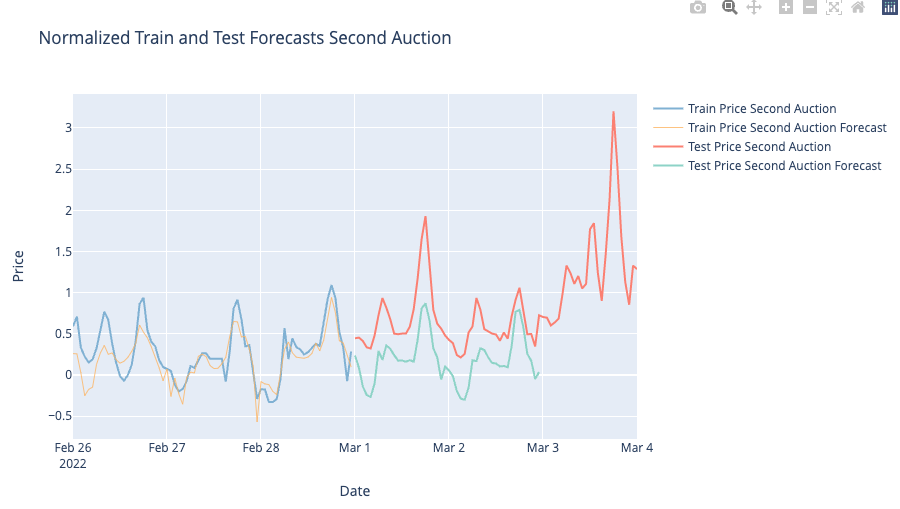

# Tensor flow: LSTM model
Unfortunately the more complex we want to make our model the more abilities and more accuarate predictions depending on the data but it also takes a lot of system RAM and time to run. Nevertheless with a GPU with more memory perhaps in the cloud this tasks would be done easier what would allow us to create better models for our forecastings. 

In [ ]:

def extract_features_from_past_data(normalized_train_auction, normalized_train_forecast_inputs, normalized_train_system_prices):
    train_features = pd.concat([normalized_train_auction,
                                  normalized_train_forecast_inputs,
                                  normalized_train_system_prices], axis=1)
    return train_features

train_features = extract_features_from_past_data(normalized_train_auction, normalized_train_forecast_inputs, normalized_train_system_prices)
# print(train_features)


print(train_features.columns)
print(f"Train features lenght: {len(train_features)}")
print(f"Train feauures shape : {train_features.shape}")

price_second_auction_index = train_features.columns.get_loc('price_second_auction')


# Prepare input data for LSTM model
x_train = []
y_train = []

# Number of steps (hours) we want to predict into the future
future = 2 * 24

# Number of steps (in this case hours) we want to use to predict the future
past = 120 * 24

# Convert the train_features DataFrame to a NumPy array
train_features_np = train_features.values

price_second_auction_index = train_features.columns.get_loc('price_second_auction')

for i in range(past, len(train_features_np) - future + 1):
    x_train.append(train_features_np[i - past:i, 0:train_features.shape[1]])
    y_train.append(train_features_np[i:i + future, price_second_auction_index])

x_train, y_train = np.array(x_train), np.array(y_train)

print('x_train shape == {}.'.format(x_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

# Define an even simpler LSTM model
model = Sequential()
model.add(LSTM(32, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(future))

model.compile(optimizer='adam', loss='mse')
model.summary()

# Fit the model with a larger batch size and fewer epochs
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)




In [ ]:
# Rest of the code for prediction and visualization remains the same

# Predicting...
n_past = 120 * 24  # 120 days * 24 hours
n_hours_for_prediction = 2 * 24  # Predict 2 days * 24 hours

# Assuming train_features has a DateTimeIndex
predict_period_dates = pd.date_range(train_features.index[-1] + pd.Timedelta(hours=1), periods=n_hours_for_prediction, freq="H").tolist()
print(predict_period_dates)

# Prepare the input data for the last n_hours_for_prediction
x_test = np.array([train_features[-n_past:].values])

# Make predictions
prediction = model.predict(x_test)  # shape = (1, 196 * 24), since we're predicting 196 days (in hours) with the given model architecture

# Create a temporary DataFrame with the same shape as the original data
temp_df = pd.DataFrame(np.zeros((n_hours_for_prediction, train_features.shape[1])), columns=train_features.columns)

# Fill the first column with the predictions
temp_df.iloc[:, 0] = prediction.flatten()

# Perform inverse transformation to rescale back to original range
# y_pred_future = scaler.inverse_transform(temp_df)[:, 0]

# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i)

# Create a DataFrame with the forecast dates and predictions
forecast_df = pd.DataFrame({'DateTime': forecast_dates, 'Prediction': temp_df.iloc[:, 0]})

print(forecast_df)
# Plot the predictions using Plotly
fig = go.Figure()

# Add a trace for the predictions
fig.add_trace(go.Scatter(x=forecast_df['DateTime'], y=forecast_df['Prediction'], mode='lines', name='Predictions'))

fig.update_layout(title='Future Price Predictions',
                  xaxis_title='Date',
                  yaxis_title='Price')

fig.show()

In [ ]:

# Select data within the desired time range
train_start_date = '2022-02-26'
train_end_date = normalized_train_auction.index.max()
train_mask = (normalized_train_auction.index >= train_start_date) & (normalized_train_auction.index <= train_end_date)
train_df = normalized_train_auction.loc[train_mask]

validated_start_date = '2022-02-26'
validated_end_date = validated_train_forecast_df.index.max()
validated_mask = (validated_train_forecast_df.index >= validated_start_date) & (validated_train_forecast_df.index <= validated_end_date)
validated_df = validated_train_forecast_df.loc[validated_mask]

test_start_date = '2022-03-01'
test_end_date = '2022-03-04'
test_mask = (normalized_test_auction.index >= test_start_date) & (normalized_test_auction.index <= test_end_date)
test_df = normalized_test_auction.loc[test_mask]

forecast_mask = (forecast_df['DateTime'] >= test_start_date) & (forecast_df['DateTime'] <= test_end_date)
forecast_df = forecast_df.loc[forecast_mask]

# Create the subplots and add the traces
fig = make_subplots()

fig.add_trace(go.Scatter(x=train_df.index, y=train_df['price_second_auction'], name='Train Price Second Auction', line=dict(color='#80b1d3')))
fig.add_trace(go.Scatter(x=validated_df.index, y=validated_df['price_second_auction_forecast'], name='Train Price Second Auction Forecast', line=dict(color='#fdb462', width=0.8)))

fig.add_trace(go.Scatter(x=test_df.index, y=test_df['price_second_auction'], name='Test Price Second Auction', line=dict(color='#fb8072')))
fig.add_trace(go.Scatter(x=forecast_df['DateTime'], y=forecast_df['Prediction'], name='Test Price Second Auction Forecast', line=dict(color='#8dd3c7')))

# Update the layout
fig.update_layout(title='Normalized Train and Test Forecasts Second Auction')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Price')

# Show the plot
fig.show()


# TRADING ALGORITHM

In [ ]:
from typing import List, Tuple

def price_first_auction(bids: List[List[Tuple[int, int]]]) -> Tuple[List[int], List[int]]:
    """
    Calculates the winning price and traded volume for each hour in a sealed bid auction.
    In a sealed bid auction, all bids are submitted simultaneously and the highest bid wins.

    Parameters:
    bids (List[List[Tuple[int, int]]]): List of bids submitted by bidders for each hour of the next operating day

    Returns:
    Tuple[List[int], List[int]]: Winning price and traded volume for each hour
    """
    winning_prices = []
    traded_volumes = []
    for hourly_bids in bids:
        if hourly_bids:
            winning_price = max(bid[1] for bid in hourly_bids)
            winning_prices.append(winning_price)
            traded_volume = sum(bid[0] for bid in hourly_bids if bid[1] == winning_price)
            traded_volumes.append(traded_volume)
        else:
            winning_prices.append(0)
            traded_volumes.append(0)
    return (winning_prices, traded_volumes)

def price_second_auction(bids: List[List[Tuple[int, int]]]) -> Tuple[List[int], List[int]]:
    """
    Calculates the winning price and traded volume for each hour in a pay-as-bid auction.
    In a pay-as-bid auction, bids are submitted one by one, and the current winning price is set to the highest bid so far.

    Parameters:
    bids (List[List[Tuple[int, int]]]): List of bids submitted by bidders for each hour of the next operating day

    Returns:
    Tuple[List[int], List[int]]: Winning price and traded volume for each hour
    """
    winning_prices = []
    traded_volumes = []
    for hourly_bids in bids:
        if hourly_bids:
            winning_price = max(bid[1] for bid in hourly_bids)
            winning_prices.append(winning_price)
            traded_volume = sum(bid[0] for bid in hourly_bids if bid[1] >= winning_price)
            traded_volumes.append(traded_volume)
        else:
            winning_prices.append(0)
            traded_volumes.append(0)
    return (winning_prices, traded_volumes)


bids = [[(10, 20), (20, 30), (30, 25), (25, 20)]]

winning_prices_first_auction = price_first_auction(bids)[0]
traded_volumes_first_auction = price_first_auction(bids)[1]
print(f"Winning prices first auction : {winning_prices_first_auction}")
print(f"Traded volumes first auction{traded_volumes_first_auction}")

winning_prices_second_auction = price_second_auction(bids)[0]
traded_volumes_second_auction = price_second_auction(bids)[1]
print(f"Winning prices second auction : {winning_prices_second_auction}")
print(f"Traded volumes second auction{traded_volumes_second_auction}")

